# Linear in Time

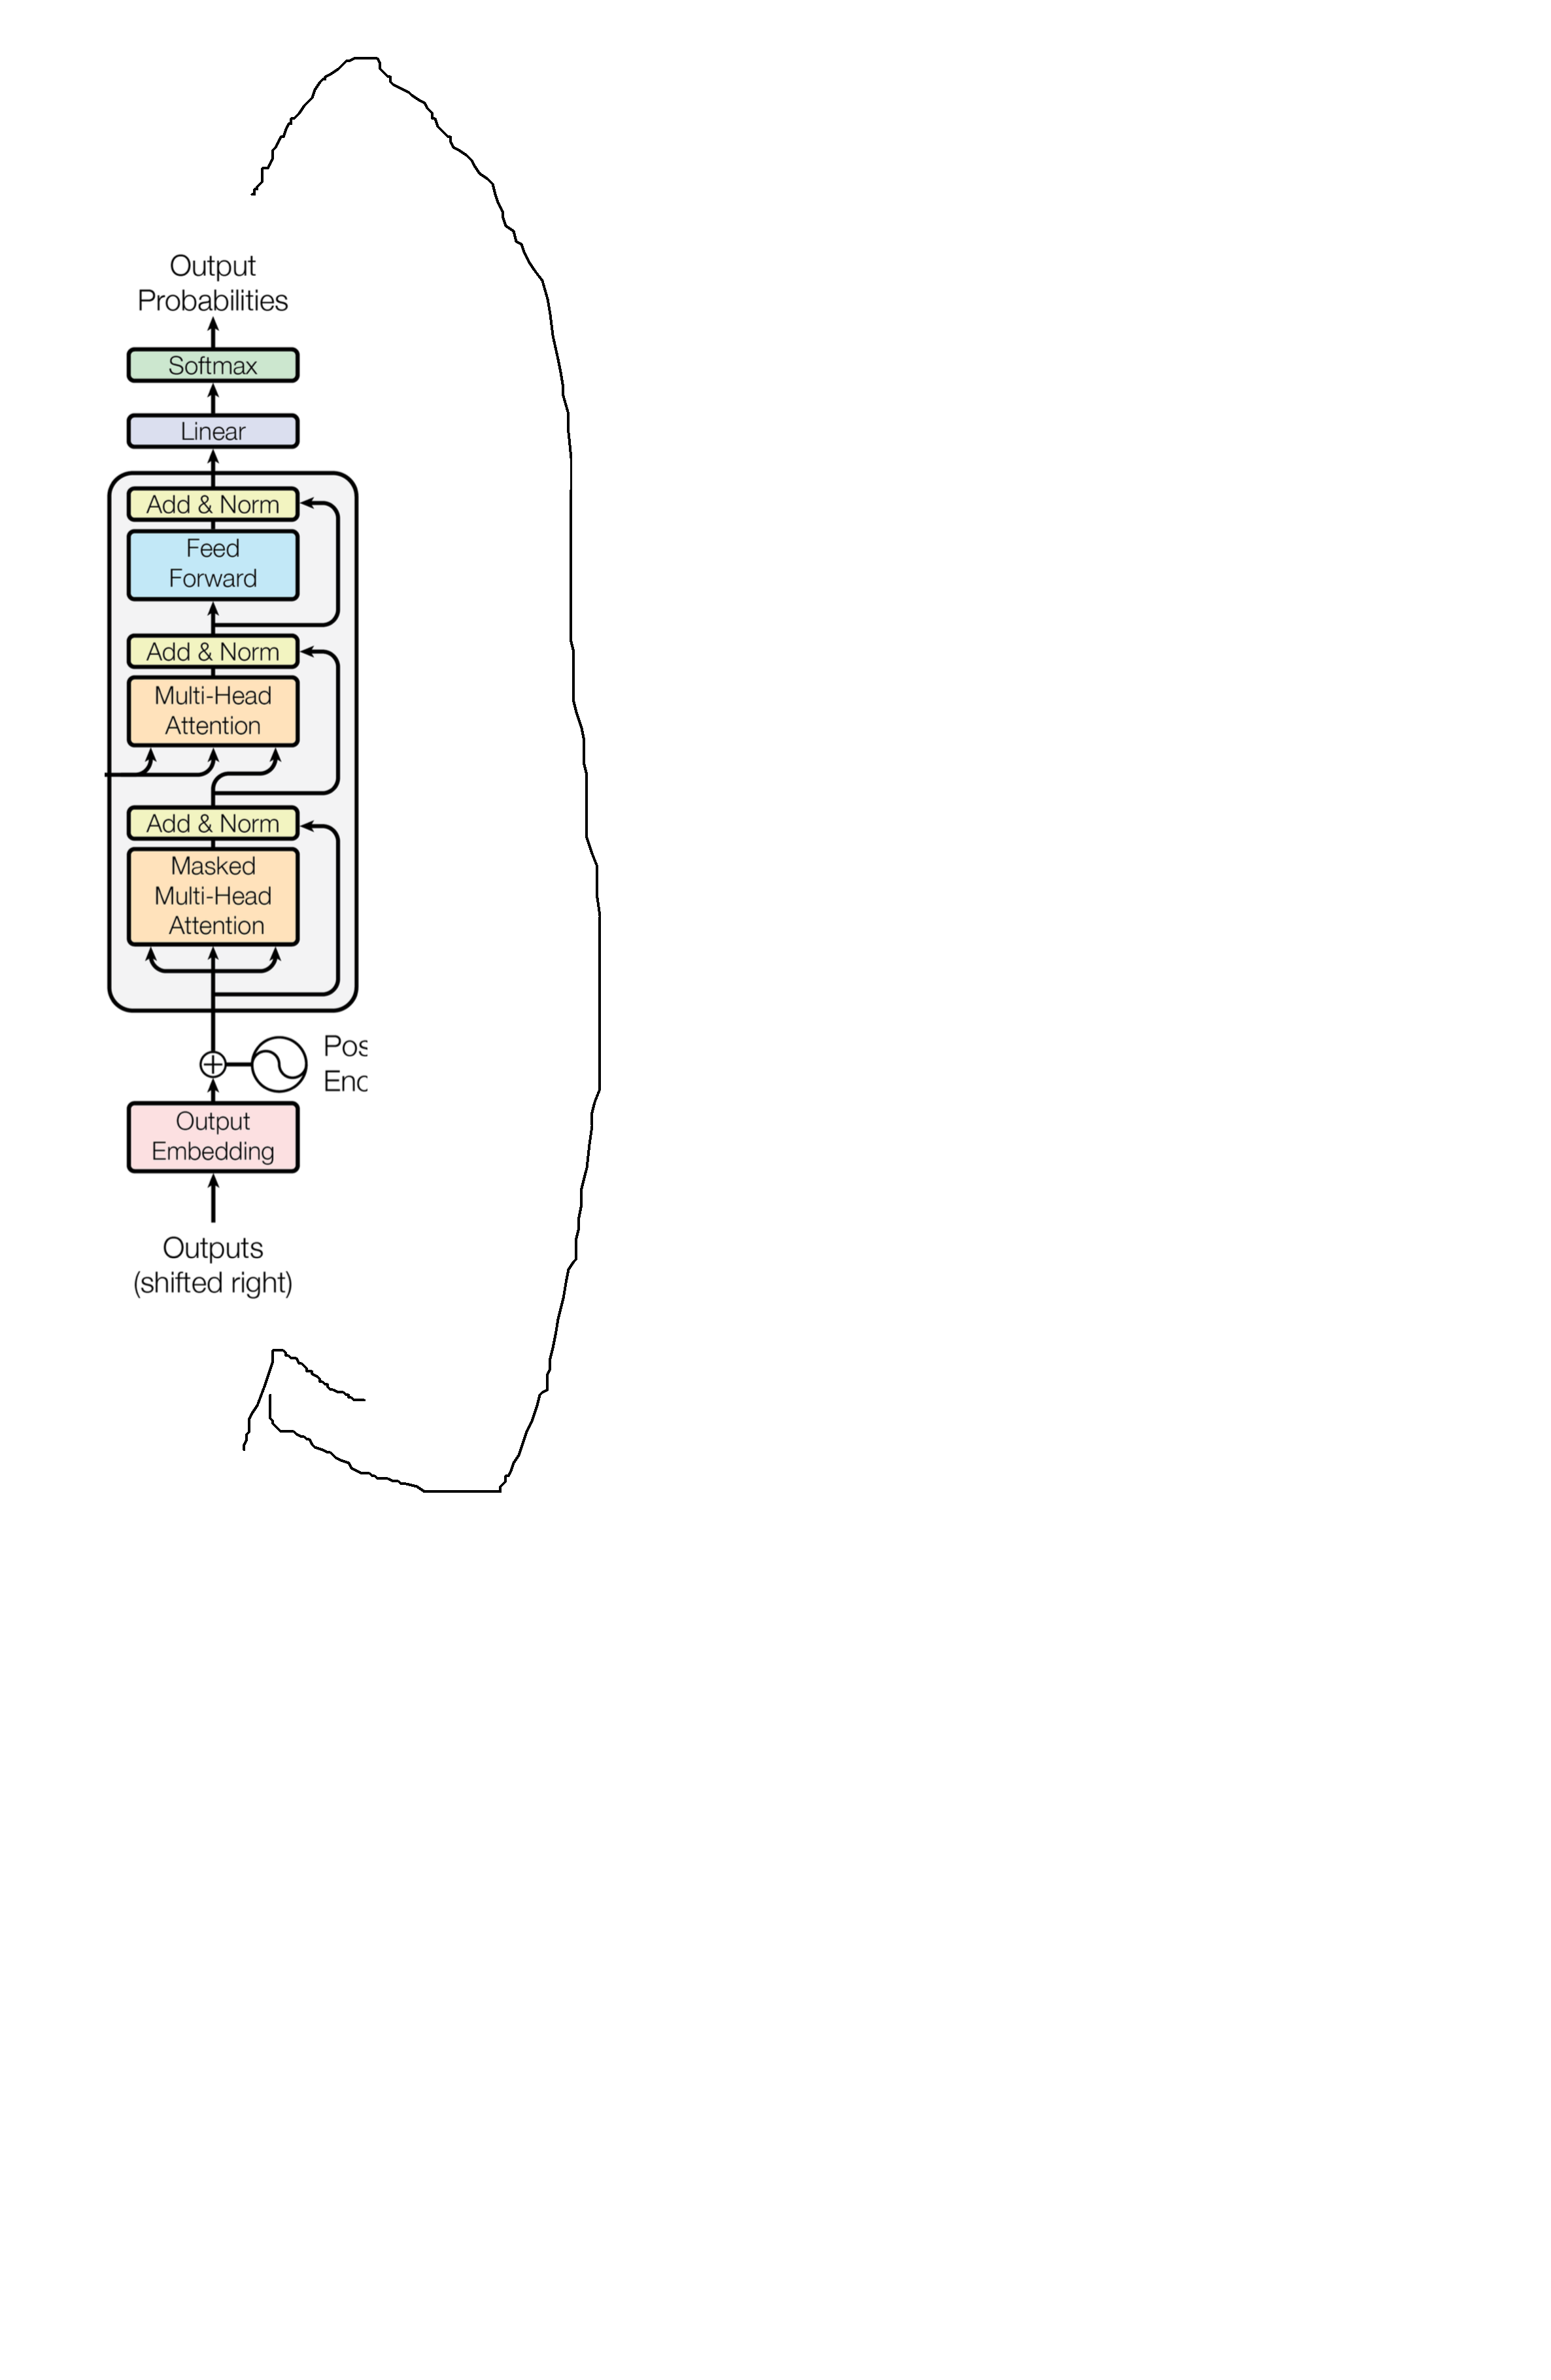

Since the decoder's ar eauto regressive output of previous time step is the input of current time step
the inputs are changin with respect to time so the gradients should also be computed wrt to time
to compute gradient for a particular time step we nee weight(same for all time step) and input for the current time step

giving the inputs for each time step at the time of back propagation for computing gradients can be done if the model is small(rnn,lstn) but attention model is large , giving inputs for time step for attention model is a tedious process so each of the component in the model will stor the input for given time step 

In [ ]:
class Fclayer(layer):
    def __init__(self,input_dim,output_dim,B1=0.9,B2=0.99):
        self.Weight=np.random.rand(input_dim, output_dim) - 0.5
        self.Vdw=np.zeros((input_dim,output_dim))
        self.Sdw=np.zeros((input_dim,output_dim))
       
        self.der_W=0 # for accumulating weight for all time steps
        self.input={} # each compnent will store the inputs for each time step external model will not give lik e done for lstm
        
        self.B1=B1
        self.B2=B2
        self.eps=0.0001
    def forward(self,data,time_step):# data shape is batchsize,....,hidden layer
        self.input[time_step]=data
        output=np.dot(data,self.Weight)
        return output
    def zero_grad(self):
        
        self.Vdw*=0
        self.Sdw*=0
       
        
    def update(self,lr):
        
        self.Vdw=self.B1*(self.Vdw)+(1-self.B1)*self.der_W
        self.Sdw=self.B2*(self.Sdw)+(1-self.B2)*(self.der_W**2+self.eps)# a small constant is added when derivative becomes zero numerator becomes infinits and loss becomes nan
       
        self.Weight=self.Weight-(lr*self.Vdw)/(np.sqrt(self.Sdw))
        # after update accumulate der weight are zero
        self.der_W=0
        self.input={}
        
        
    def backward(self,err,time_Step):
        # since derivative has to accumulated for all time steps
        ts=time_Step
        self.der_W+=np.dot((self.input[ts]).reshape(-1,self.input.shape[-1]).T,err.reshape(-1,err.shape[-1])).astype('float32') 
        # accumulating the weight of time steps  after 
        der_inp=np.dot(err,self.Weight.T) # since all time steps using same weight , while backpropagation also they should use the same weights so accumulation of derivatives is done seperately 
        
       
        if(ts==0):
            self.update(lr)
        return der_inp
